In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install lime shap eli5

     |████████████████████████████████| 276kB 4.4MB/s 
     |████████████████████████████████| 358kB 6.0MB/s 
     |████████████████████████████████| 112kB 10.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=664d51bc4a23388fec77adbb58b33b2187826429b225d9b9df6fd3e31478323a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=372219d65ef5ee559483211a5ba6237258eb14601ffb4ec7737636cffb36b4a0
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built lime shap


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
%run drive/MyDrive/Colab_Notebooks/AJ_draw.py
%run drive/MyDrive/Colab_Notebooks/AJ_ML_eda.py
%run drive/MyDrive/Colab_Notebooks/AJ_models_classifier.py

<Figure size 432x288 with 0 Axes>

In [4]:
main_folder = 'drive/MyDrive/Colab_Notebooks/dati/'
# metrics = pd.read_pickle(main_folder+"zabbix-new2")
# tickets = pd.read_pickle(main_folder+"tickets-new2")

metrics = pd.read_pickle(main_folder+"zabbix_AJ")
tickets = pd.read_pickle(main_folder+"tickets_AJ")

In [7]:
metrics.to_csv('zabbix_AJ_table.csv')
tickets.to_csv('tickets_AJ_table.csv')

In [ ]:
device = 'SQLDBONL10'
my_metrics = metrics[metrics.device == device].set_index('timestamp')[['metric', 'value']]
df = my_metrics.pivot(columns='metric', values='value').dropna(thresh=my_metrics.index.nunique() * .9, axis=1).interpolate(limit_direction='both')
df['hour'] = df.index.hour
df['day'] = df.index.dayofweek

In [ ]:
my_tickets = tickets[tickets.device == device].set_index('timestamp')

my_tickets2 = my_tickets.copy()
col_my_tickets2 = my_tickets2.columns.tolist()
my_tickets2['y'] = 1
my_tickets2 = my_tickets2.drop(col_my_tickets2, axis=1).reset_index()
my_tickets2['timestamp'] = my_tickets2['timestamp'].dt.round(freq = '1h')
df = df.reset_index()
df_new = pd.merge(df, my_tickets2, on = 'timestamp', how = 'outer')
df_new['y'] = df_new['y'].fillna(0)
df_new.set_index('timestamp', inplace=True)

hours_pre_event = 12
hour_post_event = 0

def increase_events_calculator(df, hours, direction = 1):
    hours = hours + 1
    for i in range(1,hours):
        df['y'+str(i)] = df['y'].shift(i*direction)

    for i in range(1,hours):
        df['y'] = df['y']+df['y'+str(i)]

    df['y'] = df['y'].fillna(0)
    dropy = ['y'+str(i) for i in range(1,hours)]
    df = df.drop(dropy, axis = 1)
    return df

df_new = increase_events_calculator(df_new, hour_post_event)
df_new = increase_events_calculator(df_new, hours_pre_event, direction = -1)
df_new['y'] = df_new['y'].replace([i for i in range(1,int(df_new['y'].max()+1))], 1).astype(int)

df = df_new

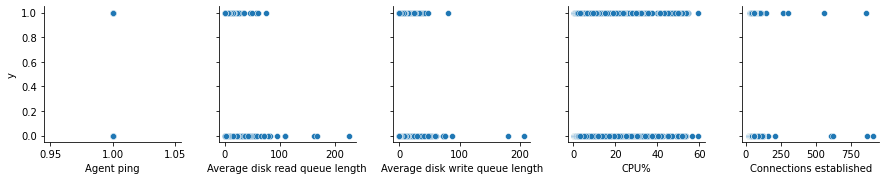

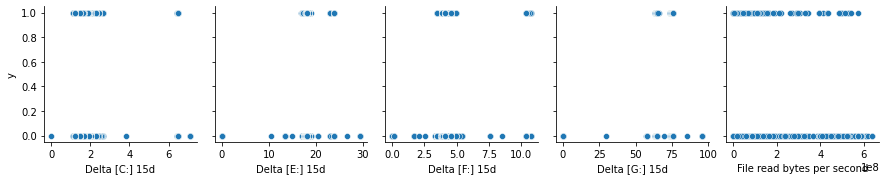

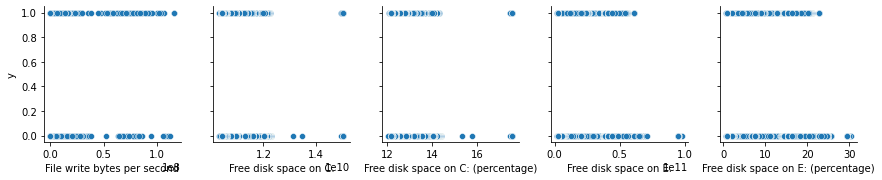

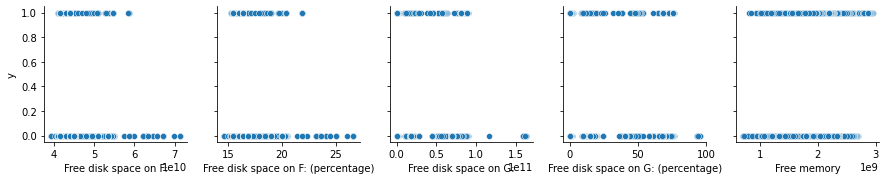

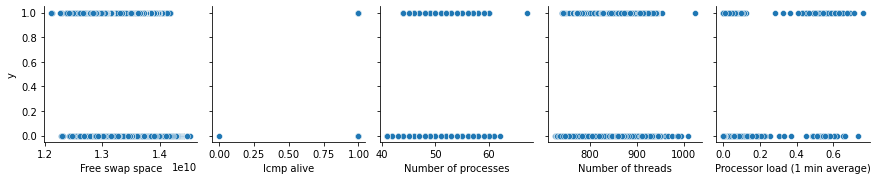

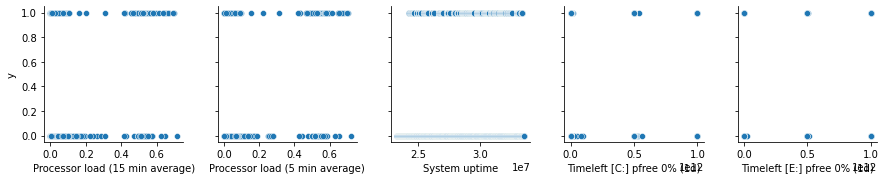

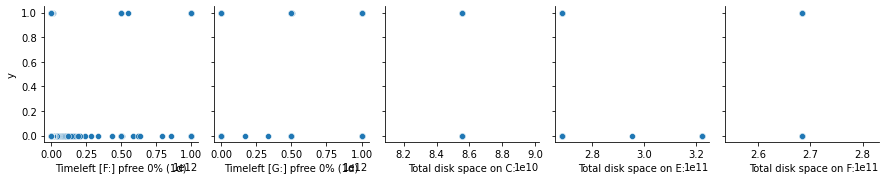

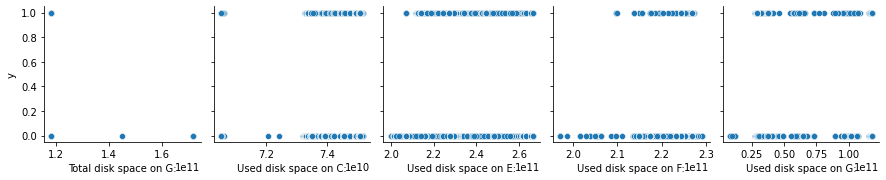

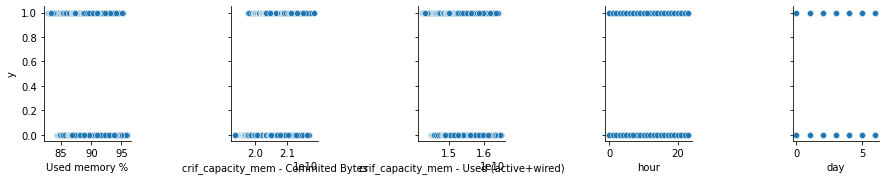

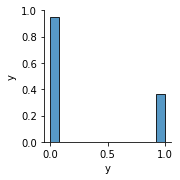

In [ ]:
peeking(df).plot_correlation_roy('y')

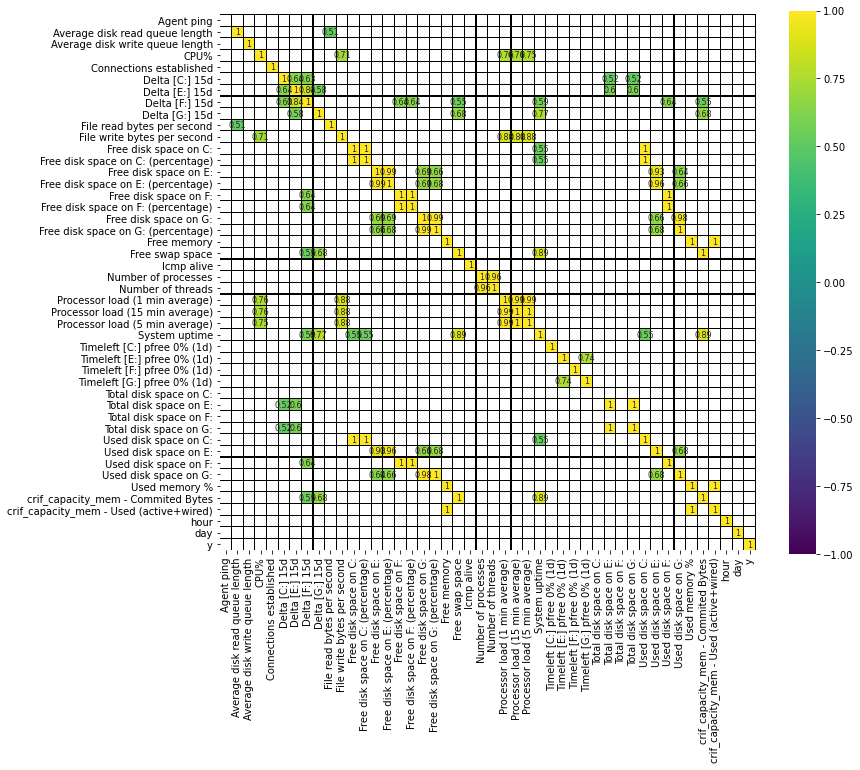

In [ ]:
correlation_with_target, correlation_within_features = learning(df).correlation_matrix('y', corr_value_w_targhet = 1)

In [ ]:
correlation_with_target

Number of processes                        0.004515
Used disk space on G:                      0.006144
Free disk space on G: (percentage)         0.010079
Icmp alive                                 0.011628
Average disk write queue length            0.012451
Delta [F:] 15d                             0.016778
Free disk space on G:                      0.020453
Delta [E:] 15d                             0.021558
Connections established                    0.027837
File read bytes per second                 0.029429
Average disk read queue length             0.039827
Delta [C:] 15d                             0.047839
Number of threads                          0.048197
Used disk space on E:                      0.048865
Timeleft [F:] pfree 0% (1d)                0.052716
Free disk space on E: (percentage)         0.067536
Free disk space on C:                      0.070078
Used disk space on C:                      0.070080
Free disk space on C: (percentage)         0.070094
Free disk sp

In [ ]:
correlation_within_features

['Free disk space on C: (percentage)',
 'Free disk space on E: (percentage)',
 'Free disk space on F: (percentage)',
 'Free disk space on G: (percentage)',
 'Number of threads',
 'Processor load (15 min average)',
 'Processor load (5 min average)',
 'Total disk space on G:',
 'Used disk space on C:',
 'Used disk space on E:',
 'Used disk space on F:',
 'Used disk space on G:',
 'Used memory %',
 'crif_capacity_mem - Commited Bytes',
 'crif_capacity_mem - Used (active+wired)']

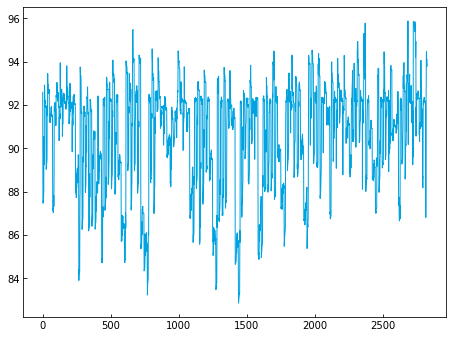

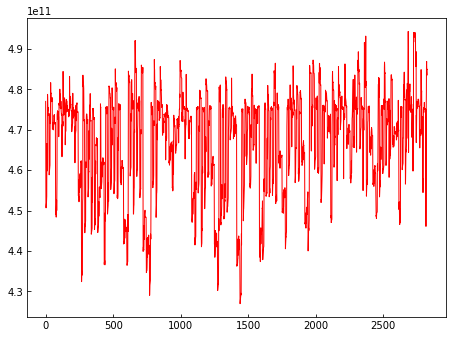

In [ ]:
ds().nuova_fig(1)
ds().dati(x = np.arange(df.shape[0]), y = df['Used memory %'].to_numpy())
# ds().dati(x = np.arange(df.shape[0]), y = df['Free memory'].to_numpy()*30, colore='red')
# ds().range_plot(bottomX = 500, topX = 1000)
ds().porta_a_finestra()

ds().nuova_fig(2)
# ds().dati(x = np.arange(df.shape[0]), y = df['Used memory %'].to_numpy())
ds().dati(x = np.arange(df.shape[0]), y = df['crif_capacity_mem - Used (active+wired)'].to_numpy()*30, colore='red')
# ds().range_plot(bottomX = 500, topX = 1000)
ds().porta_a_finestra()

In [ ]:
def balanced_train_test_split(df, test_size=.7):
    # Calcolo quant'è il 70% del numero di "1"
    num_tickets_training = int(df.y.sum() * test_size)

    # Faccio cumulative sum per considerare nel training set un numero di ticket = num_tickets_training
    cumsum = df.y.cumsum()

    # Conto quante righe ho che stanno dopo i primi <num_tickets_training> ticket
    num_val_tickets = cumsum[cumsum > num_tickets_training].shape[0]

    # Splitto con test_size fissato
    training_set, validation_set = train_test_split(df, test_size=num_val_tickets, shuffle=False)

    return training_set, validation_set

#replace the simbols not compatible with xgboost from the columns names
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

training_set, test_set = balanced_train_test_split(df)
print(len(test_set[test_set.y == 1]) / len(test_set))

0.32821229050279327


In [ ]:
learn = learning_class()
models = learn.get_models(['RandomForestClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'SVC', 'ExtraTreeClassifier', 'LogisticRegression'])
normal, sparse = 'normal', 'sparse'

models['deep learning ' + normal +' '+ sparse] = learn.get_deep_learning_model(input_dl = training_set.loc[:, training_set.columns != 'y'].shape[1],net_type = normal, loss_type = sparse)
models, _ = learn.train_models(models, training_set.loc[:, training_set.columns != 'y'], training_set.y, shuffle = False, epochs = 30)
prob, pred = learn.prob_matrix_generator(models, test_set.loc[:, test_set.columns != 'y'], num_classes=2)
score = learn.score_models(test_set.y, prob, pred)
score

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,0,1,2,3,4,5,6,7
model,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,SVC,ExtraTreeClassifier,LogisticRegression,deep learning normal sparse,Ensamble
accuracy,0.75,0.704,0.592,0.595,0.603,0.627,0.672,0.714
mae,0.25,0.296,0.408,0.405,0.397,0.373,0.328,0.286
roc score class 0,0.83,0.793,0.524,0.472,0.581,0.687,0.5,0.737
roc score class 1,0.83,0.793,0.524,0.472,0.581,0.687,0.5,0.737


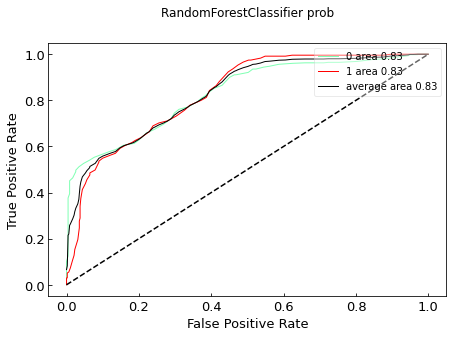

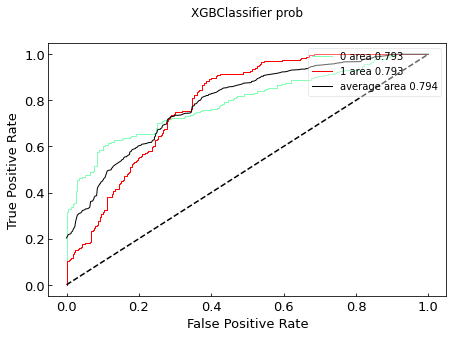

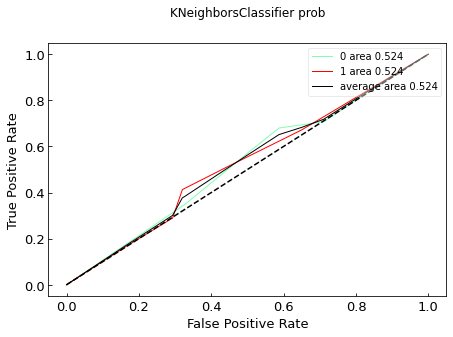

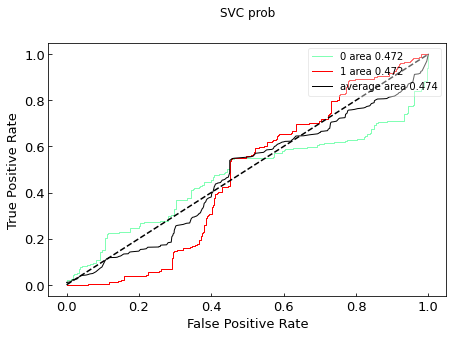

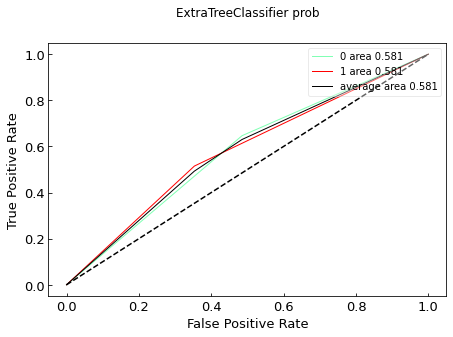

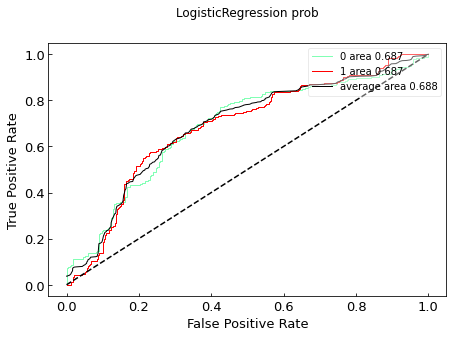

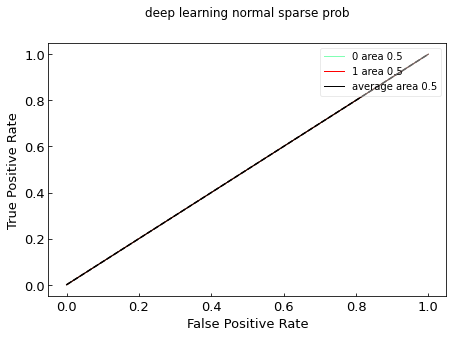

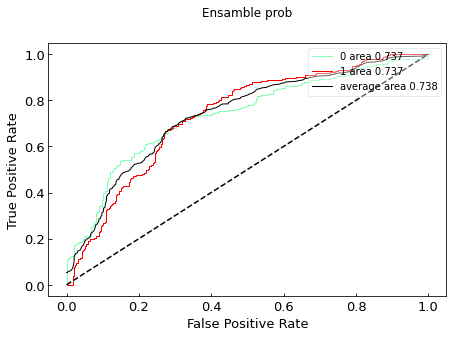

In [ ]:
learn.plot_roc_curve(prob, test_set.y)

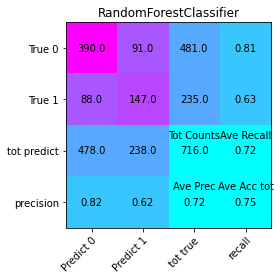

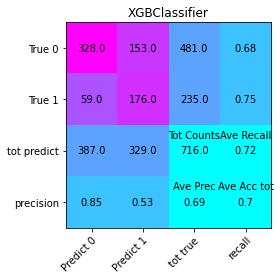

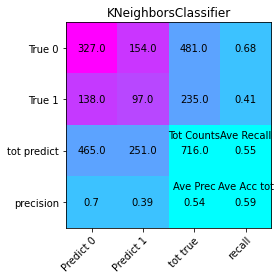

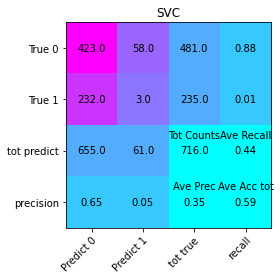

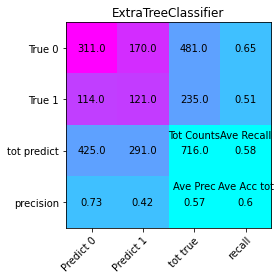

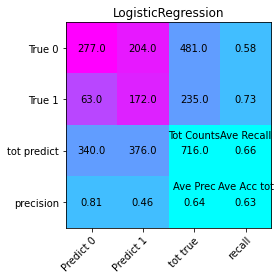

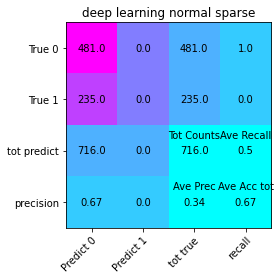

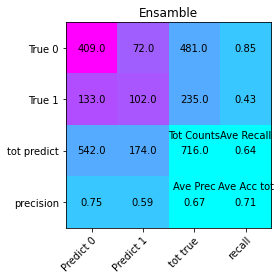

,accuracy_tot,accuracy_average,precision_average,recall_average
RandomForestClassifier,0.750000,0.718171,0.72,0.72
XGBClassifier,0.703911,0.715424,0.69,0.72
KNeighborsClassifier,0.592179,0.546300,0.54,0.55
SVC,0.594972,0.446092,0.35,0.44
ExtraTreeClassifier,0.603352,0.580732,0.57,0.58
LogisticRegression,0.627095,0.653899,0.64,0.66
deep learning normal sparse,0.671788,0.500000,0.34,0.50
Ensamble,0.713687,0.642177,0.67,0.64


In [ ]:
learn.score_accuracy_recall(pred, test_set.y)